### Setup

In [1]:
pip install -r requirements.txt

  Using cached scikit-learn-0.21.3.tar.gz (12.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached shap-0.40.0-cp39-cp39-win_amd64.whl (432 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1
  Running setup.py install for scikit-learn: started
  Running setup.py install for scikit-learn: finished with status 'error'
  Rolling back uninstall of scikit-learn
  Moving to c:\users\john bernardin\appdata\local\packages\pythonsoftwarefoundation.python.3.9_qbz5n2kfra8p0\localcache\local-packages\python39\site-packages\scikit_learn-1.2.1.dist-info\
   from C:\Users\John Bernardin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\~cikit_learn-1.2.1.dist-info
  Moving to c:\users\john bernardin\appdata\local\packages\pythonsoftwa

  DEPRECATION: scikit-learn is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  Running setup.py install for scikit-learn did not run successfully.
  exit code: 1
  
  [40 lines of output]
  Partial import of sklearn during the build process.
  C:\Users\John Bernardin\AppData\Local\Temp\pip-install-a6a5pkpw\scikit-learn_878b23f3baad42efa370c78c6e78e62d\setup.py:122: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For mo

In [2]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret
from config import config_dict

In [3]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [4]:
file_name = "SPY.csv"
data = preprocess.load_data(file_name)
data.columns = data.columns.str.capitalize()
data.head(3)

,Date,Open,Close,Low,High,Volume
0,1999-11-01,136.500000,88.217185,135.562500,137.000,4006500.0
1,1999-11-02,135.968704,87.586742,134.593704,137.250,6516900.0
2,1999-11-03,136.000000,88.176513,135.125000,136.375,7222300.0


In [5]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=config_dict["data"]["train_split_size"], plot_df=True)

Starting with data preparation...
Completed.


In [6]:
train_df.shape, test_df.shape

((5292, 7), (589, 7))

### Explore the Data

In [7]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

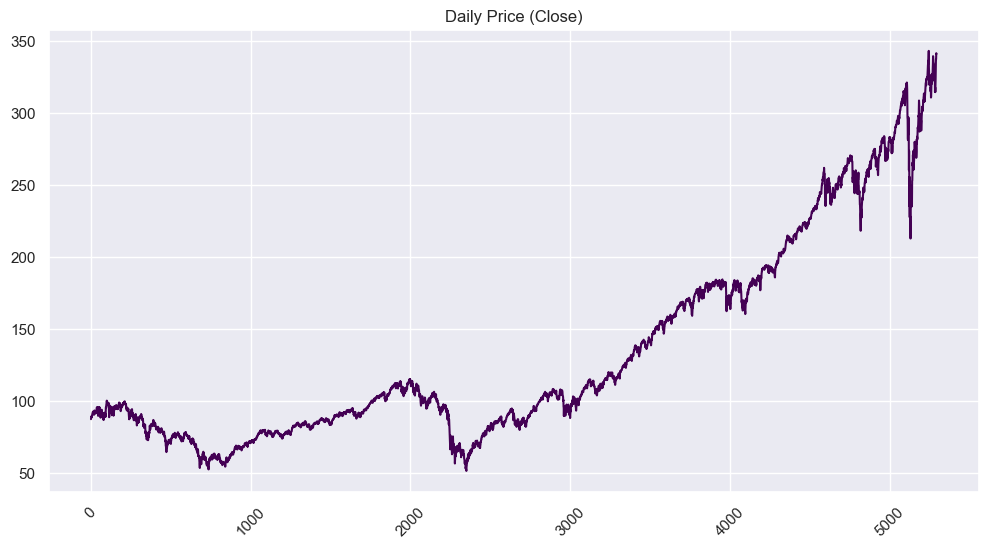

In [8]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

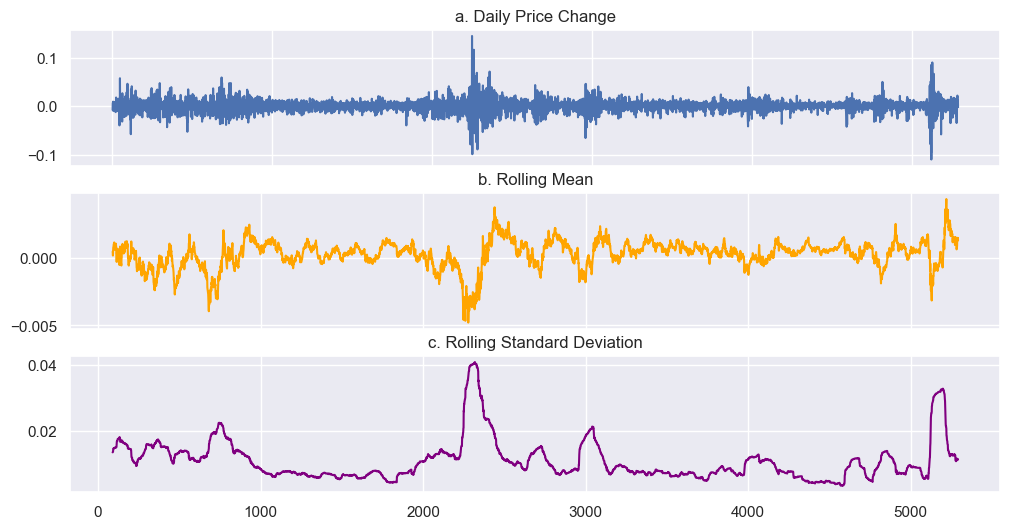

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [10]:
sequence_length = 30
batch_size = config_dict["training"]["batch_size"]
n_epochs = config_dict["training"]["num_epoch"]
n_epochs_stop = 5
label_name = 'Close'

In [11]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
Epoch 1 train loss: 0.009 test loss: 0.1102
Epoch 2 train loss: 0.0395 test loss: 0.1762
Epoch 3 train loss: 0.0552 test loss: 0.0072
Epoch 4 train loss: 0.0623 test loss: 0.2089
Epoch 5 train loss: 0.0202 test loss: 0.0165
Epoch 6 train loss: 0.0033 test loss: 0.0041
Epoch 7 train loss: 0.0032 test loss: 0.0099
Epoch 8 train loss: 0.0028 test loss: 0.0104
Epoch 9 train loss: 0.0026 test loss: 0.0062
Epoch 10 train loss: 0.0038 test loss: 0.005
Early stopping.
Completed.


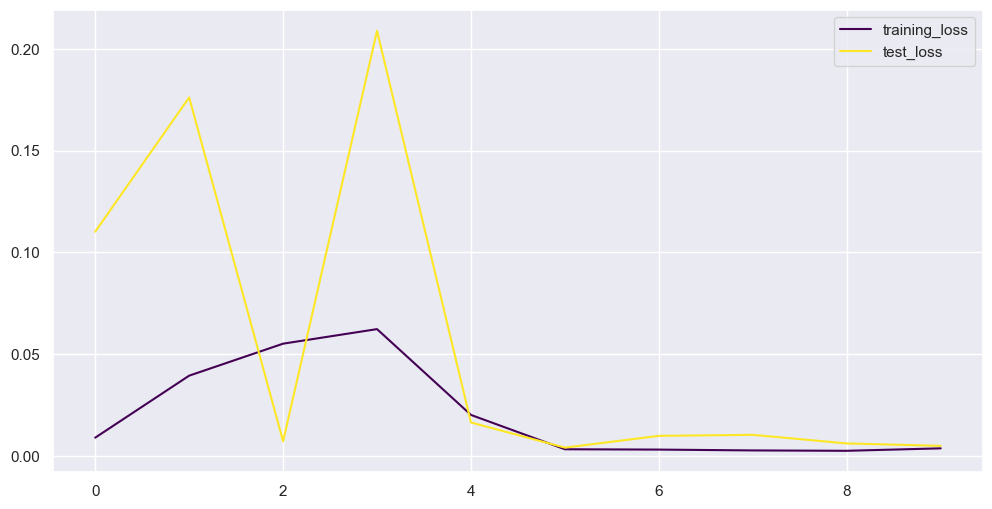

In [12]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [13]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

((559,), (559,))

In [14]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')

Error on all test data:
RMSE:  19.23
MAE:  15.13




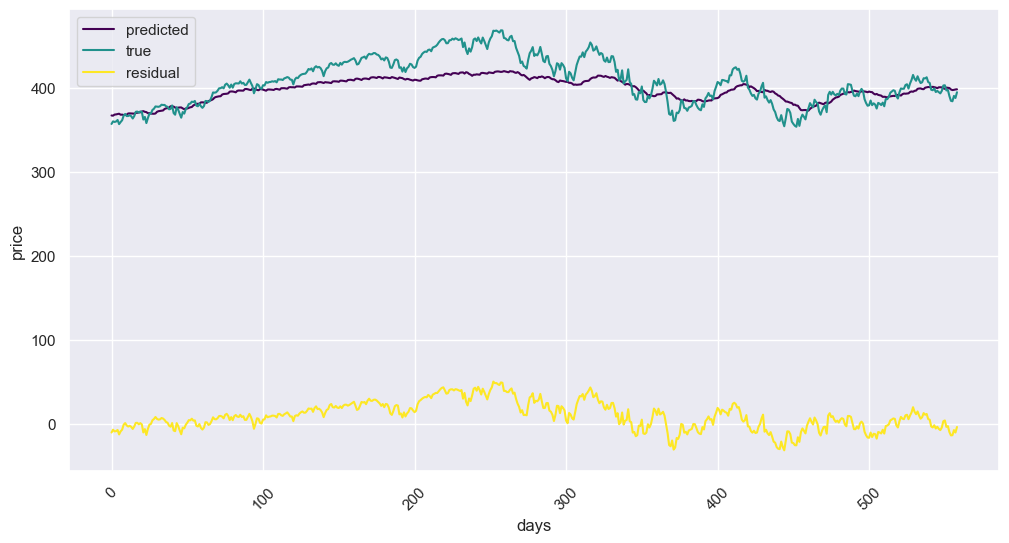

In [15]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [16]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [17]:
background_data_size = 900
test_sample_size = 100
sequence_length = 30

In [18]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [19]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()

,Close,Volume,High_Low_Pct,Open_Close_Pct,Day_Of_Week,Month_Of_Year,Quarter_Of_Year,days
0,9.314133e-10,1.781295e-11,1.596091e-10,2.848670e-09,6.976429e-10,2.345587e-09,1.793764e-09,-30
1,1.276768e-11,1.294177e-10,4.259402e-10,6.319273e-09,1.223905e-09,3.763469e-09,2.769863e-09,-29
2,2.037190e-09,3.446614e-10,9.104030e-10,1.290464e-08,2.257177e-09,6.197439e-09,4.236913e-09,-28
3,6.162006e-09,7.568146e-10,1.792699e-09,2.516210e-08,4.182126e-09,1.032788e-08,6.480659e-09,-27
4,1.463703e-08,1.547829e-09,3.396426e-09,4.794844e-08,7.696310e-09,1.723505e-08,9.958091e-09,-26


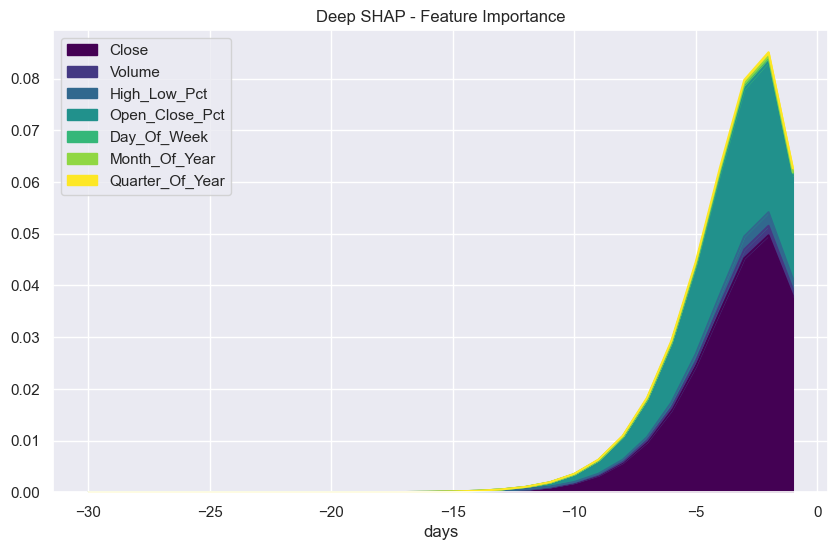

In [20]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()